## This is implementation of paper NULL-text Inversion for Editing Real Images using Guided Diffusion Models
https://arxiv.org/abs/2211.09794

Let's start with DDIM inversion implementation

In [1]:
# !pip install git+https://github.com/huggingface/diffusers/
# this implementation works on diffusers >= 0.8.0
from diffusers import StableDiffusionPipeline
from torch import autocast, inference_mode
import torch
import numpy as np

/opt/venv/lib/python3.8/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [2]:
# you might want to login to huggingface or use token when initializing pipeline below
!huggingface-cli login

In [3]:
# adapted and updated from https://github.com/huggingface/diffusers/blob/main/src/diffusers/schedulers/scheduling_ddim.py

# Copyright 2022 Stanford University Team and The HuggingFace Team. All rights reserved.
#
# Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
#     http://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# DISCLAIMER: This code is strongly influenced by https://github.com/pesser/pytorch_diffusion
# and https://github.com/hojonathanho/diffusion

import math
from dataclasses import dataclass
from typing import Optional, Tuple, Union

import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from PIL import Image

from diffusers.configuration_utils import ConfigMixin, register_to_config
from diffusers.utils import BaseOutput, deprecate
from diffusers.schedulers.scheduling_utils import SchedulerMixin


@dataclass
class DDIMSchedulerOutput(BaseOutput):
    """
    Output class for the scheduler's step function output.

    Args:
        prev_sample (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)` for images):
            Computed sample (x_{t-1}) of previous timestep. `prev_sample` should be used as next model input in the
            denoising loop.
        next_sample (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)` for images):
            Computed sample (x_{t+1}) of previous timestep. `next_sample` should be used as next model input in the
            reverse denoising loop.
        pred_original_sample (`torch.FloatTensor` of shape `(batch_size, num_channels, height, width)` for images):
            The predicted denoised sample (x_{0}) based on the model output from the current timestep.
            `pred_original_sample` can be used to preview progress or for guidance.
    """

    prev_sample: Optional[torch.FloatTensor] = None
    next_sample: Optional[torch.FloatTensor] = None
    pred_original_sample: Optional[torch.FloatTensor] = None


def betas_for_alpha_bar(num_diffusion_timesteps, max_beta=0.999) -> torch.Tensor:
    """
    Create a beta schedule that discretizes the given alpha_t_bar function, which defines the cumulative product of
    (1-beta) over time from t = [0,1].

    Contains a function alpha_bar that takes an argument t and transforms it to the cumulative product of (1-beta) up
    to that part of the diffusion process.


    Args:
        num_diffusion_timesteps (`int`): the number of betas to produce.
        max_beta (`float`): the maximum beta to use; use values lower than 1 to
                     prevent singularities.

    Returns:
        betas (`np.ndarray`): the betas used by the scheduler to step the model outputs
    """

    def alpha_bar(time_step):
        return math.cos((time_step + 0.008) / 1.008 * math.pi / 2) ** 2

    betas = []
    for i in range(num_diffusion_timesteps):
        t1 = i / num_diffusion_timesteps
        t2 = (i + 1) / num_diffusion_timesteps
        betas.append(min(1 - alpha_bar(t2) / alpha_bar(t1), max_beta))
    return torch.tensor(betas)


class DDIMScheduler(SchedulerMixin, ConfigMixin):
    """
    Denoising diffusion implicit models is a scheduler that extends the denoising procedure introduced in denoising
    diffusion probabilistic models (DDPMs) with non-Markovian guidance.

    [`~ConfigMixin`] takes care of storing all config attributes that are passed in the scheduler's `__init__`
    function, such as `num_train_timesteps`. They can be accessed via `scheduler.config.num_train_timesteps`.
    [`~ConfigMixin`] also provides general loading and saving functionality via the [`~ConfigMixin.save_config`] and
    [`~ConfigMixin.from_config`] functions.

    For more details, see the original paper: https://arxiv.org/abs/2010.02502

    Args:
        num_train_timesteps (`int`): number of diffusion steps used to train the model.
        beta_start (`float`): the starting `beta` value of inference.
        beta_end (`float`): the final `beta` value.
        beta_schedule (`str`):
            the beta schedule, a mapping from a beta range to a sequence of betas for stepping the model. Choose from
            `linear`, `scaled_linear`, or `squaredcos_cap_v2`.
        trained_betas (`np.ndarray`, optional):
            option to pass an array of betas directly to the constructor to bypass `beta_start`, `beta_end` etc.
        clip_sample (`bool`, default `True`):
            option to clip predicted sample between -1 and 1 for numerical stability.
        set_alpha_to_one (`bool`, default `True`):
            each diffusion step uses the value of alphas product at that step and at the previous one. For the final
            step there is no previous alpha. When this option is `True` the previous alpha product is fixed to `1`,
            otherwise it uses the value of alpha at step 0.
        steps_offset (`int`, default `0`):
            an offset added to the inference steps. You can use a combination of `offset=1` and
            `set_alpha_to_one=False`, to make the last step use step 0 for the previous alpha product, as done in
            stable diffusion.

    """

    @register_to_config
    def __init__(
        self,
        num_train_timesteps: int = 1000,
        beta_start: float = 0.0001,
        beta_end: float = 0.02,
        beta_schedule: str = "linear",
        trained_betas: Optional[np.ndarray] = None,
        clip_sample: bool = True,
        set_alpha_to_one: bool = True,
        steps_offset: int = 0,
    ):
        if trained_betas is not None:
            self.betas = torch.from_numpy(trained_betas)
        elif beta_schedule == "linear":
            self.betas = torch.linspace(beta_start, beta_end, num_train_timesteps, dtype=torch.float32)
        elif beta_schedule == "scaled_linear":
            # this schedule is very specific to the latent diffusion model.
            self.betas = (
                torch.linspace(beta_start**0.5, beta_end**0.5, num_train_timesteps, dtype=torch.float32) ** 2
            )
        elif beta_schedule == "squaredcos_cap_v2":
            # Glide cosine schedule
            self.betas = betas_for_alpha_bar(num_train_timesteps)
        else:
            raise NotImplementedError(f"{beta_schedule} does is not implemented for {self.__class__}")

        self.alphas = 1.0 - self.betas
        self.alphas_cumprod = torch.cumprod(self.alphas, dim=0)

        # At every step in ddim, we are looking into the previous alphas_cumprod
        # For the final step, there is no previous alphas_cumprod because we are already at 0
        # `set_alpha_to_one` decides whether we set this parameter simply to one or
        # whether we use the final alpha of the "non-previous" one.
        self.final_alpha_cumprod = torch.tensor(1.0) if set_alpha_to_one else self.alphas_cumprod[0]

        # standard deviation of the initial noise distribution
        self.init_noise_sigma = 1.0

        # setable values
        self.num_inference_steps = None
        self.timesteps = torch.from_numpy(np.arange(0, num_train_timesteps)[::-1].copy().astype(np.int64))

    def _get_variance(self, timestep, prev_timestep):
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.final_alpha_cumprod
        beta_prod_t = 1 - alpha_prod_t
        beta_prod_t_prev = 1 - alpha_prod_t_prev

        variance = (beta_prod_t_prev / beta_prod_t) * (1 - alpha_prod_t / alpha_prod_t_prev)

        return variance

    def set_timesteps(self, num_inference_steps: int, device: Union[str, torch.device] = None):
        """
        Sets the discrete timesteps used for the diffusion chain. Supporting function to be run before inference.
        Args:
            num_inference_steps (`int`):
                the number of diffusion steps used when generating samples with a pre-trained model.
        """
        self.num_inference_steps = num_inference_steps
        step_ratio = self.config.num_train_timesteps // self.num_inference_steps
        # creates integer timesteps by multiplying by ratio
        # casting to int to avoid issues when num_inference_step is power of 3
        timesteps = (np.arange(0, num_inference_steps) * step_ratio).round()[::-1].copy().astype(np.int64)
        self.timesteps = torch.from_numpy(timesteps).to(device)
        self.timesteps += self.config.steps_offset
        
    def scale_model_input(self, sample: torch.FloatTensor, timestep: Optional[int] = None) -> torch.FloatTensor:
        """
        Ensures interchangeability with schedulers that need to scale the denoising model input depending on the
        current timestep.
        Args:
            sample (`torch.FloatTensor`): input sample
            timestep (`int`, optional): current timestep
        Returns:
            `torch.FloatTensor`: scaled input sample
        """
        return sample

    def step(
        self,
        model_output: torch.FloatTensor,
        timestep: int,
        sample: torch.FloatTensor,
        eta: float = 0.0,
        use_clipped_model_output: bool = False,
        generator=None,
        return_dict: bool = True,
    ) -> Union[DDIMSchedulerOutput, Tuple]:
        """
        Predict the sample at the previous timestep by reversing the SDE. Core function to propagate the diffusion
        process from the learned model outputs (most often the predicted noise).

        Args:
            model_output (`torch.FloatTensor`): direct output from learned diffusion model.
            timestep (`int`): current discrete timestep in the diffusion chain.
            sample (`torch.FloatTensor`):
                current instance of sample being created by diffusion process.
            eta (`float`): weight of noise for added noise in diffusion step.
            use_clipped_model_output (`bool`): TODO
            generator: random number generator.
            return_dict (`bool`): option for returning tuple rather than DDIMSchedulerOutput class

        Returns:
            [`~schedulers.scheduling_utils.DDIMSchedulerOutput`] or `tuple`:
            [`~schedulers.scheduling_utils.DDIMSchedulerOutput`] if `return_dict` is True, otherwise a `tuple`. When
            returning a tuple, the first element is the sample tensor.

        """
        if self.num_inference_steps is None:
            raise ValueError(
                "Number of inference steps is 'None', you need to run 'set_timesteps' after creating the scheduler"
            )

        # See formulas (12) and (16) of DDIM paper https://arxiv.org/pdf/2010.02502.pdf
        # Ideally, read DDIM paper in-detail understanding

        # Notation (<variable name> -> <name in paper>
        # - pred_noise_t -> e_theta(x_t, t)
        # - pred_original_sample -> f_theta(x_t, t) or x_0
        # - std_dev_t -> sigma_t
        # - eta -> η
        # - pred_sample_direction -> "direction pointing to x_t"
        # - pred_prev_sample -> "x_t-1"

        # 1. get previous step value (=t-1)
        prev_timestep = timestep - self.config.num_train_timesteps // self.num_inference_steps

        # 2. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_prev = self.alphas_cumprod[prev_timestep] if prev_timestep >= 0 else self.final_alpha_cumprod

        beta_prod_t = 1 - alpha_prod_t

        # 3. compute predicted original sample from predicted noise also called
        # "predicted x_0" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)

        # 4. Clip "predicted x_0"
        if self.config.clip_sample:
            pred_original_sample = torch.clamp(pred_original_sample, -1, 1)

        # 5. compute variance: "sigma_t(η)" -> see formula (16)
        # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
        variance = self._get_variance(timestep, prev_timestep)
        std_dev_t = eta * variance ** (0.5)

        if use_clipped_model_output:
            # the model_output is always re-derived from the clipped x_0 in Glide
            model_output = (sample - alpha_prod_t ** (0.5) * pred_original_sample) / beta_prod_t ** (0.5)

        # 6. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        pred_sample_direction = (1 - alpha_prod_t_prev - std_dev_t**2) ** (0.5) * model_output

        # 7. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        prev_sample = alpha_prod_t_prev ** (0.5) * pred_original_sample + pred_sample_direction

        if eta > 0:
            device = model_output.device if torch.is_tensor(model_output) else "cpu"
            noise = torch.randn(model_output.shape, generator=generator).to(device)
            variance = self._get_variance(timestep, prev_timestep) ** (0.5) * eta * noise

            prev_sample = prev_sample + variance

        if not return_dict:
            return (prev_sample,)

        return DDIMSchedulerOutput(prev_sample=prev_sample, pred_original_sample=pred_original_sample)

    def reverse_step(
        self,
        model_output: torch.FloatTensor,
        timestep: int,
        sample: torch.FloatTensor,
        eta: float = 0.0,
        use_clipped_model_output: bool = False,
        generator=None,
        return_dict: bool = True,
    ) -> Union[DDIMSchedulerOutput, Tuple]:
        """
        Predict the sample at the previous timestep by reversing the SDE. Core function to propagate the diffusion
        process from the learned model outputs (most often the predicted noise).

        Args:
            model_output (`torch.FloatTensor`): direct output from learned diffusion model.
            timestep (`int`): current discrete timestep in the diffusion chain.
            sample (`torch.FloatTensor`):
                current instance of sample being created by diffusion process.
            eta (`float`): weight of noise for added noise in diffusion step.
            use_clipped_model_output (`bool`): TODO
            generator: random number generator.
            return_dict (`bool`): option for returning tuple rather than DDIMSchedulerOutput class

        Returns:
            [`~schedulers.scheduling_utils.DDIMSchedulerOutput`] or `tuple`:
            [`~schedulers.scheduling_utils.DDIMSchedulerOutput`] if `return_dict` is True, otherwise a `tuple`. When
            returning a tuple, the first element is the sample tensor.

        """
        if self.num_inference_steps is None:
            raise ValueError(
                "Number of inference steps is 'None', you need to run 'set_timesteps' after creating the scheduler"
            )

        # See formulas (12) and (16) of DDIM paper https://arxiv.org/pdf/2010.02502.pdf
        # Ideally, read DDIM paper in-detail understanding

        # Notation (<variable name> -> <name in paper>
        # - pred_noise_t -> e_theta(x_t, t)
        # - pred_original_sample -> f_theta(x_t, t) or x_0
        # - std_dev_t -> sigma_t
        # - eta -> η
        # - pred_sample_direction -> "direction pointing to x_t"
        # - pred_prev_sample -> "x_t-1"

        # 1. get previous step value (=t-1)
        next_timestep = min(self.config.num_train_timesteps - 2,
                            timestep + self.config.num_train_timesteps // self.num_inference_steps)

        # 2. compute alphas, betas
        alpha_prod_t = self.alphas_cumprod[timestep]
        alpha_prod_t_next = self.alphas_cumprod[next_timestep] if next_timestep >= 0 else self.final_alpha_cumprod

        beta_prod_t = 1 - alpha_prod_t

        # 3. compute predicted original sample from predicted noise also called
        # "predicted x_0" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        pred_original_sample = (sample - beta_prod_t ** (0.5) * model_output) / alpha_prod_t ** (0.5)

        # 4. Clip "predicted x_0"
        if self.config.clip_sample:
            pred_original_sample = torch.clamp(pred_original_sample, -1, 1)

        # 5. TODO: simple noising implementatiom
        next_sample = self.add_noise(pred_original_sample,
                                     model_output,
                                     torch.LongTensor([next_timestep]))

        # # 5. compute variance: "sigma_t(η)" -> see formula (16)
        # # σ_t = sqrt((1 − α_t−1)/(1 − α_t)) * sqrt(1 − α_t/α_t−1)
        # variance = self._get_variance(next_timestep, timestep)
        # std_dev_t = eta * variance ** (0.5)

        # if use_clipped_model_output:
        #     # the model_output is always re-derived from the clipped x_0 in Glide
        #     model_output = (sample - alpha_prod_t ** (0.5) * pred_original_sample) / beta_prod_t ** (0.5)

        # # 6. compute "direction pointing to x_t" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        # pred_sample_direction = (1 - alpha_prod_t_next - std_dev_t**2) ** (0.5) * model_output

        # # 7. compute x_t without "random noise" of formula (12) from https://arxiv.org/pdf/2010.02502.pdf
        # next_sample = alpha_prod_t_next ** (0.5) * pred_original_sample + pred_sample_direction

        if not return_dict:
            return (next_sample,)

        return DDIMSchedulerOutput(next_sample=next_sample, pred_original_sample=pred_original_sample)

    def add_noise(
        self,
        original_samples: torch.FloatTensor,
        noise: torch.FloatTensor,
        timesteps: torch.IntTensor,
    ) -> torch.FloatTensor:
        if self.alphas_cumprod.device != original_samples.device:
            self.alphas_cumprod = self.alphas_cumprod.to(original_samples.device)
        if timesteps.device != original_samples.device:
            timesteps = timesteps.to(original_samples.device)

        sqrt_alpha_prod = self.alphas_cumprod[timesteps] ** 0.5
        sqrt_alpha_prod = sqrt_alpha_prod.flatten()
        while len(sqrt_alpha_prod.shape) < len(original_samples.shape):
            sqrt_alpha_prod = sqrt_alpha_prod.unsqueeze(-1)

        sqrt_one_minus_alpha_prod = (1 - self.alphas_cumprod[timesteps]) ** 0.5
        sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.flatten()
        while len(sqrt_one_minus_alpha_prod.shape) < len(original_samples.shape):
            sqrt_one_minus_alpha_prod = sqrt_one_minus_alpha_prod.unsqueeze(-1)

        noisy_samples = sqrt_alpha_prod * original_samples + sqrt_one_minus_alpha_prod * noise
        return noisy_samples

    def __len__(self):
        return self.config.num_train_timesteps


In [4]:
device = 'cuda'
# don't forget to add your token or comment if already logged in
pipe = StableDiffusionPipeline.from_pretrained("runwayml/stable-diffusion-v1-5", 
                                               scheduler=DDIMScheduler(beta_end=0.012,
                                                                       beta_schedule="scaled_linear",
                                                                       beta_start=0.00085),
                                               use_auth_token="<YOUR-HF-TOKEN>").to(device)

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

In [5]:
def show_lat(latents):
    # utility function for visualization of diffusion process
    with torch.no_grad():
        images = pipe.decode_latents(latents)
        im = pipe.numpy_to_pil(images)[0].resize((128, 128))
    return im

## Reverse DDIM

Use our implementation of DDIM sampler with reverse step to obtain noise from real image

  0%|          | 0/51 [00:00<?, ?it/s]

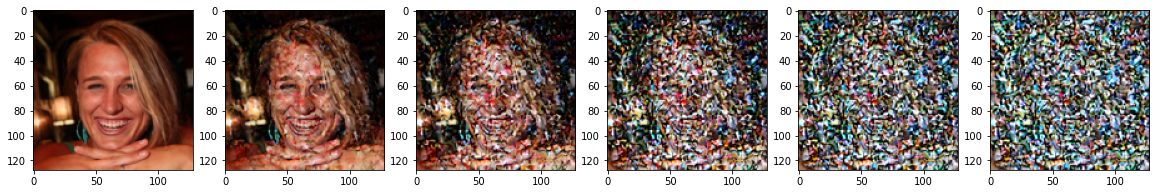

In [6]:
def preprocess(image):
    w, h = image.size
    w, h = map(lambda x: x - x % 32, (w, h))  # resize to integer multiple of 32
    image = image.resize((w, h), resample=Image.LANCZOS)
    image = np.array(image).astype(np.float32) / 255.0
    image = image[None].transpose(0, 3, 1, 2)
    image = torch.from_numpy(image)
    return 2.0 * image - 1.0

def im2latent(pipe, im, generator):
    init_image = preprocess(im).to(pipe.device)
    init_latent_dist = pipe.vae.encode(init_image).latent_dist
    init_latents = init_latent_dist.sample(generator=generator)
    
    return init_latents * 0.18215


batch_size = 1
# photo from ffhq
init_image = Image.open("00001.jpg").resize((512,512))
# fix seed
g = torch.Generator(device=pipe.device).manual_seed(84)

image_latents = im2latent(pipe, init_image, g)
pipe.scheduler.set_timesteps(51)
# use text describing an image
source_prompt = "a photo of a woman"
context = pipe._encode_prompt(source_prompt, pipe.device, 1, False, "")

plt.figure(figsize=(20,8))
decoded_latents = image_latents.clone()
with autocast("cuda"), inference_mode():
    # we are pivoting timesteps as we are moving in opposite direction
    timesteps = pipe.scheduler.timesteps.flip(0)
    # this would be our targets for pivoting
    init_trajectory = torch.empty(len(timesteps), *decoded_latents.size()[1:], device=decoded_latents.device, dtype=decoded_latents.dtype)
    for i, t in enumerate(tqdm(timesteps)):
        init_trajectory[i:i+1] = decoded_latents
        noise_pred = pipe.unet(decoded_latents, t, encoder_hidden_states=context).sample
        decoded_latents = pipe.scheduler.reverse_step(noise_pred, t, decoded_latents).next_sample
        if i % 10 == 0:
            plt.subplot(1,6,i//10+1)
            plt.imshow(show_lat(decoded_latents))

Let's try to reconstruct image from noise using same prompt

  0%|          | 0/51 [00:00<?, ?it/s]

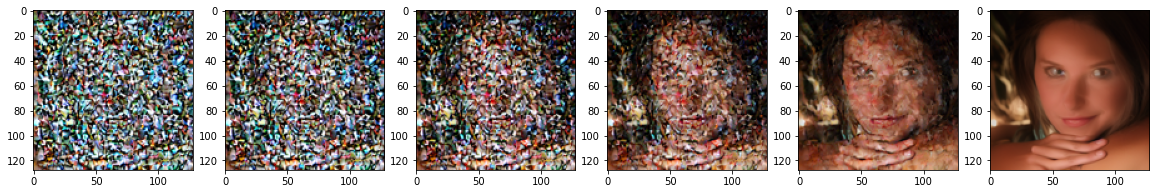

In [7]:
plt.figure(figsize=(20,8))
latents = decoded_latents.clone()
with autocast("cuda"), inference_mode():
    for i, t in enumerate(tqdm(pipe.scheduler.timesteps)):
        latents = pipe.scheduler.step(
            pipe.unet(latents, t, encoder_hidden_states=context).sample, t, latents
        ).prev_sample
        if i % 10 == 0:
            plt.subplot(1,6,i//10+1)
            plt.imshow(show_lat(latents))

With naive approach inversion on this image didn't work. Also note that this is a hard sample, for some images DDIM inversion just works.

Believe me, classifier-free guidance wouldn't help here.

So let's try to use approach from the paper with optimizing unconditional text embedding

Now we have init trajectory from the paper to pivot z_i for backward process

In [8]:
# we would need to flip trajectory values for pivoting in right direction
init_trajectory = init_trajectory.cpu().flip(0)
_ = pipe.vae.requires_grad_(False)
_ = pipe.text_encoder.requires_grad_(False)
_ = pipe.unet.requires_grad_(False)

  0%|          | 0/51 [00:00<?, ?it/s]

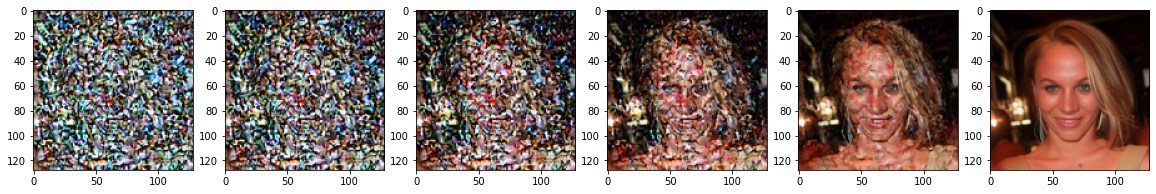

In [9]:
from torch.optim import AdamW

latents = decoded_latents.clone()

# I've noticed that scale < 1 works better
scale = 0.6

context_uncond = pipe._encode_prompt("", pipe.device, 1, False, "")
# we will be optimizing uncond text embedding
context_uncond.requires_grad_(True)

# use same text
prompt = "a photo of a woman"
context_cond = pipe._encode_prompt(prompt, pipe.device, 1, False, "")

# default lr works
opt = AdamW([context_uncond])

# concat latents for classifier-free guidance
latents = torch.cat([latents, latents])
latents.requires_grad_(True)
context = torch.cat((context_uncond, context_cond))

plt.figure(figsize=(20,8))
with autocast(device):
    for i, t in enumerate(tqdm(pipe.scheduler.timesteps)):
        latents = pipe.scheduler.scale_model_input(latents, t)
        uncond, cond = pipe.unet(latents, t, encoder_hidden_states=context).sample.chunk(2)
        with torch.enable_grad():
            latents = pipe.scheduler.step(uncond + scale * (cond - uncond), t, latents, generator=g).prev_sample
        
        opt.zero_grad()
        # optimize uncond text emb
        pivot_value = init_trajectory[[i]].to(pipe.device)
        (latents - pivot_value).mean().backward()
        opt.step()
        latents = latents.detach()
        
        if i % 10 == 0:
            plt.subplot(1,6,i//10+1)
            plt.imshow(show_lat(latents))

Much better!

We could try to make image editing by slightly changing target prompt and increasing guidance scale

  0%|          | 0/51 [00:00<?, ?it/s]

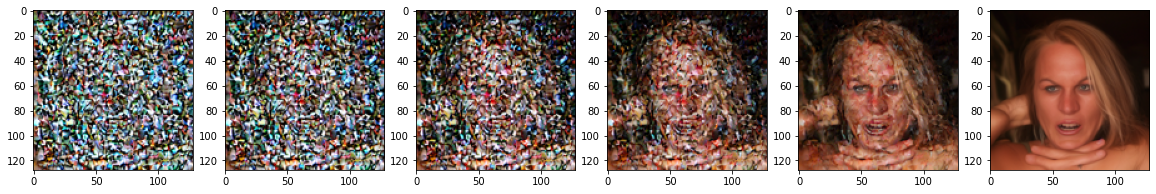

In [10]:
from torch.optim import AdamW

latents = decoded_latents.clone()

# for image editing purposes scale from 1 to 2 works good
scale = 1.5

context_uncond = pipe._encode_prompt("", pipe.device, 1, False, "")
# we will be optimizing uncond text embedding
context_uncond.requires_grad_(True)

# use same text
prompt = "a photo of an angry woman"
context_cond = pipe._encode_prompt(prompt, pipe.device, 1, False, "")

# default lr works
opt = AdamW([context_uncond])

# concat latents for classifier-free guidance
latents = torch.cat([latents, latents])
latents.requires_grad_(True)
context = torch.cat((context_uncond, context_cond))

plt.figure(figsize=(20,8))
with autocast(device):
    for i, t in enumerate(tqdm(pipe.scheduler.timesteps)):
        latents = pipe.scheduler.scale_model_input(latents, t)
        uncond, cond = pipe.unet(latents, t, encoder_hidden_states=context).sample.chunk(2)
        with torch.enable_grad():
            latents = pipe.scheduler.step(uncond + scale * (cond - uncond), t, latents, generator=g).prev_sample
        
        opt.zero_grad()
        # optimize uncond text emb
        pivot_value = init_trajectory[[i]].to(pipe.device)
        (latents - pivot_value).mean().backward()
        opt.step()
        latents = latents.detach()
        
        if i % 10 == 0:
            plt.subplot(1,6,i//10+1)
            plt.imshow(show_lat(latents))